# Plot some OLBIN publication database

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#!pip install pandas matplotlib ipympl

# load some modules for later use
import pandas
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict 

#%matplotlib widget

In [3]:
# define some common plot settings

plt.rcParams['figure.figsize'] = [17, 8]
# Set the default color cycle
colormap = plt.get_cmap('tab20').colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colormap) 
plt.rc('font', size=20)

# Load main dataset (csv format)

In [4]:
olbin = pandas.read_csv("http://bibdbmgr.jmmc.fr/tags.xql")

# Display impact on scientific results for some categories

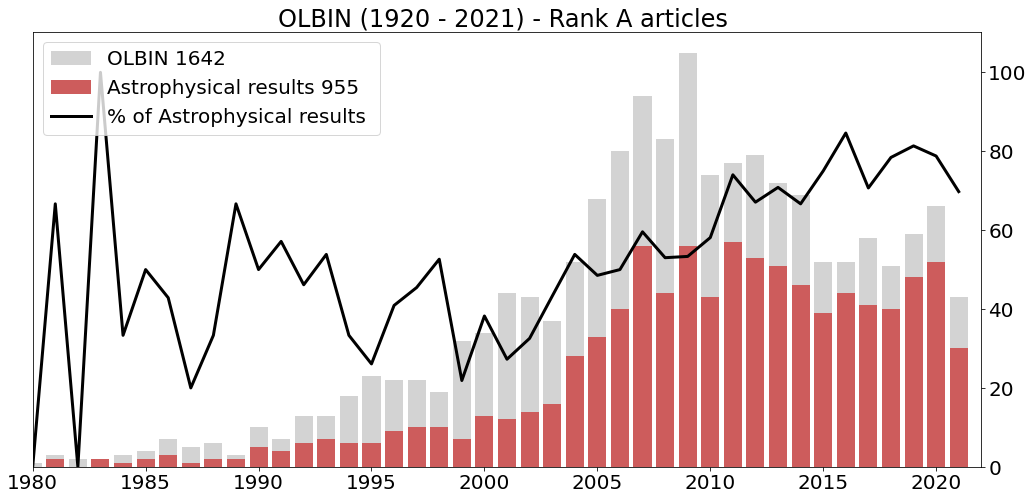

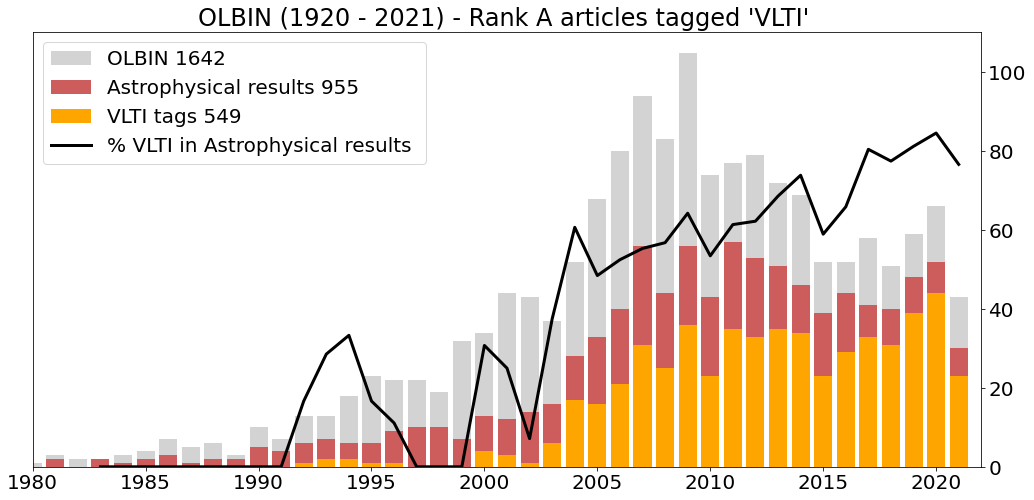

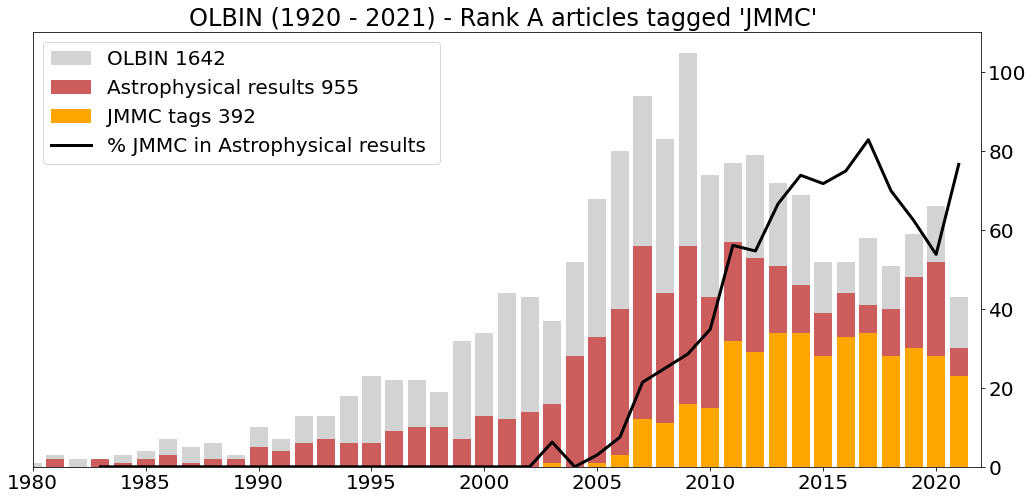

In [8]:
# reuse main datasource 
#olbin = pandas.read_csv("http://bibdbmgr.jmmc.fr/tags.xql")

for tag in (None,"VLTI","JMMC"):
    # create data sets
    s={}
    s1=s["OLBIN"]=olbin.total_pubs
    s2=s["Astrophysical results"]=olbin["Astrophysical results"]
    if tag :
        s3=s[tag]=olbin[tag]
        s4=s["% citation"]=s3/s2*100
    else:
        s4=s["%"]=s2/s1*100
    #TODO generates legend info dynamically from previous dataset

    # figure
    fig, ax = plt.subplots()
    if tag :
        op = ax.set_title("OLBIN (%s - %s) - Rank A articles tagged '%s' "%(min(olbin.YEAR), max(olbin.YEAR), tag))
    else :
        op = ax.set_title("OLBIN (%s - %s) - Rank A articles "%(min(olbin.YEAR), max(olbin.YEAR)))
    p1 = ax.bar(olbin.YEAR, s1, color='lightgrey')
    p2 = ax.bar(olbin.YEAR, s2, color='indianred')
    #p4 = ax.bar(olbin.YEAR, s4, color='red')
    p4 = ax.plot (olbin.YEAR, s4, color='black', linewidth=3)

    if tag :
        p3 = ax.bar(olbin.YEAR, s3, color='orange')    
        op = ax.legend((p1[0], p2[0], p3[0], p4[0]), ("OLBIN "+str(sum(s1)),"Astrophysical results "+str(sum(s2)), tag + " tags "+str(sum(s3)), "% "+tag+" in Astrophysical results "), loc='upper left')
    else:
        op = ax.legend((p1[0], p2[0],p4[0]), ("OLBIN "+str(sum(s1)),"Astrophysical results "+str(sum(s2)),"% of Astrophysical results " ), loc='upper left')
    op = ax.set_xlim(1980,max(olbin.YEAR)+1)
    op = ax.yaxis.tick_right()




# Follow JMMC products cited in the OLBIN corpus

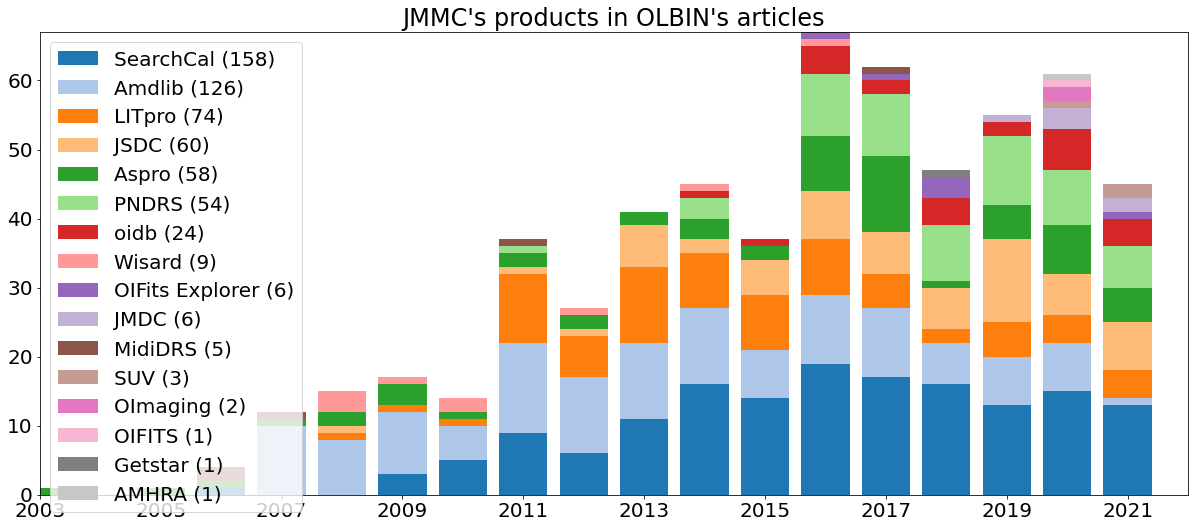

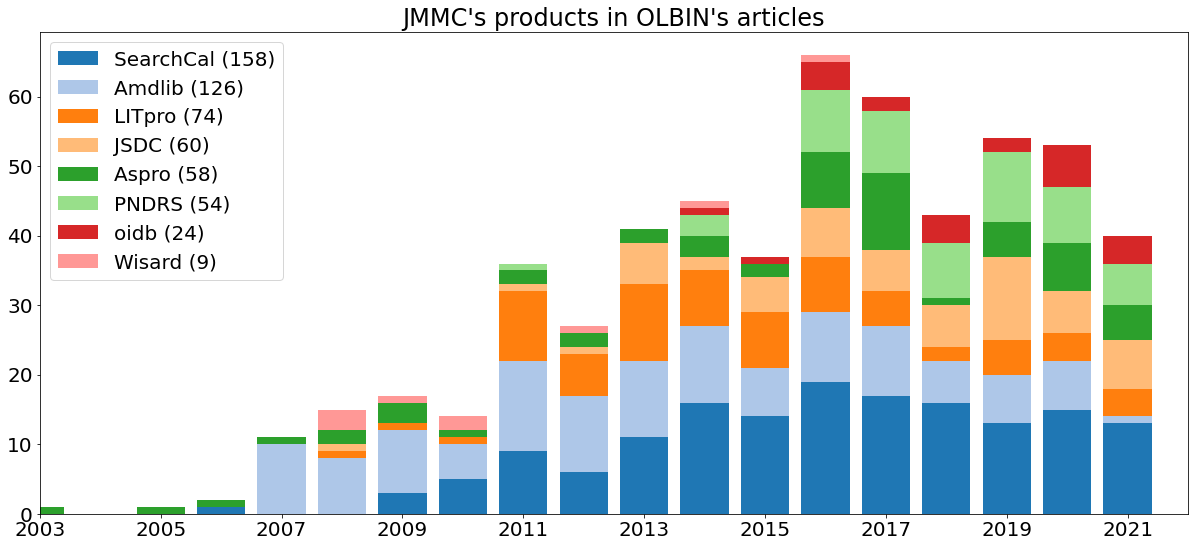

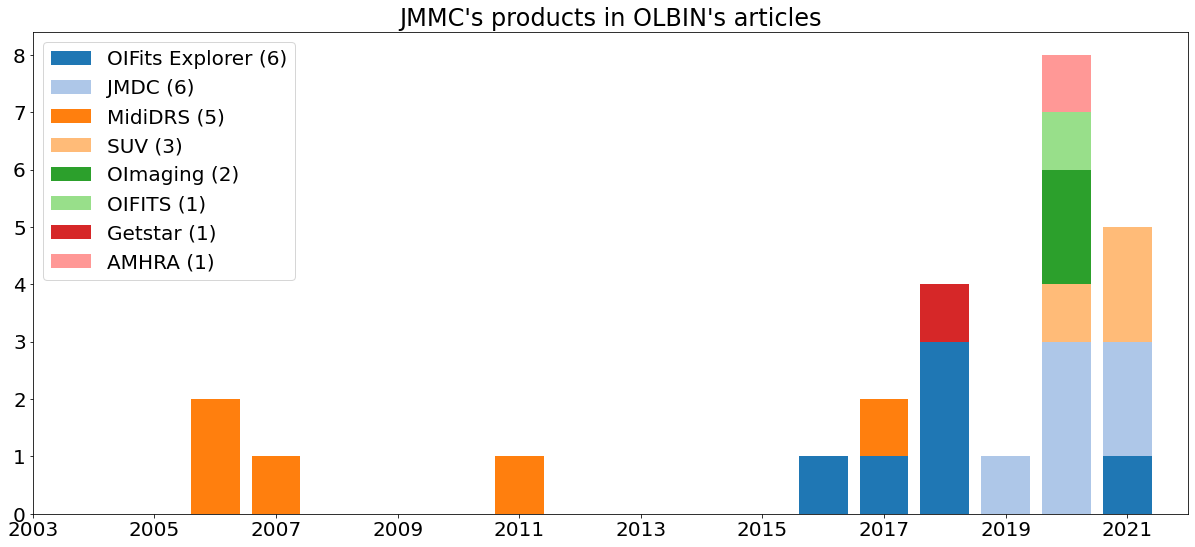

In [6]:
# TODO fix categories retrieval from web to make it generic
categories={}
categories["HIDDEN"]=(  "JMMC",  "Aspro",  "SearchCal",  "Amdlib",  "LITpro",  "Wisard",  "MidiDRS",  "JSDC",  "oidb",  "PNDRS",  "OIFits Explorer",  "Getstar",  "JMDC",  "OImaging",  "SUV",  "AMHRA",  "OIFITS"    )

# keep cols of interest
min_year=2003
max_year=max(olbin.YEAR)+1

cols = {}
for (k,v) in olbin.items():
    if k in categories["HIDDEN"] and not "JMMC" in k:
        cols[k]=v
        
#split into 2 list given list's sum 
sums=  OrderedDict( (key, sum(value)) for (key,value) in cols.items())
sorted_by_sum= sorted(sums, key=sums.get)
m=int(len(cols)/2)
scols1=OrderedDict()
scols2=OrderedDict()
scols=OrderedDict()

for name in reversed(sorted_by_sum):
    scols[name]=cols[name]
    if name in sorted_by_sum[0:m]:
        scols2[name]=cols[name]
    else:
        scols1[name]=cols[name]

# loop overs subsets
subsets = (scols, scols1, scols2)
#subsets = [scols]
# for stacked bars
for scols in subsets:                
    fig, ax = plt.subplots()
    flag = True
    for c in scols:          
        if flag:
            ax.bar(olbin.YEAR, scols[c], label=c+" ("+str(sum(scols[c]))+")")
            flag=False
            bot=scols[c]
        else:
            ax.bar(olbin.YEAR, scols[c], bottom=bot, label=c+" ("+str(sum(scols[c]))+")")            
            bot= np.add(bot, scols[c]).tolist()                    
    ax.set_xlim(min_year,max_year)
    ax.set_xticks(np.arange(min_year,max_year, 2))
    ax.legend(loc='upper left')    
    ax.set_title("JMMC's products in OLBIN's articles")
    fig.tight_layout()
    
# for stacket plot    
if False:
#if True:
  for scols in subsets:        
    values=[]
    fig, ax = plt.subplots()
    for c in scols:
        values.append(scols[c])
    ax.stackplot(olbin.YEAR, values, labels=scols)
    ax.set_xlim(min_year,max_year)
    ax.set_xticks(np.arange(min_year,max_year, 2))
    ax.legend(loc='upper left')        
    fig.tight_layout()
 